# Predicting Customer Churn in Telecommunication Operators
Customer turnover refers to a decision made by the customer on the term of business relationship. Customer loyalty and customer turnover always add up to 100%. If a company has a 60% loyalty rate, then customer loss taxes are 40%. According to the 80/20 customer profitability rule, 20% of customers are generating 80% of revenue. Therefore, it is very important to predict the users who are likely to abandon the business relationship and the factors that affect how the customer's decisions.<br>
In this project, I predicted Customer Churn at a Telecommunications Operator using python and frameworks.

In [1]:
# Importing libraries and frameworks
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline 

import scipy.stats
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import f_classif,chi2
from sklearn.model_selection import train_test_split

import random

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from sklearn.externals import joblib

import warnings
warnings.filterwarnings("ignore")

/home/naiara/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


## Importing dataset

In [2]:
# Importing train dataset
df_train = pd.read_csv("data/projeto4_telecom_treino.csv")
df_test = pd.read_csv("data/projeto4_telecom_teste.csv")

## Exploratory Analysis and Feature Engineering

In [198]:
# Checking dataset features
print(df_train.shape[1])
df_train.head()

21


,id,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,1,KS,128,area_code_415,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,no
1,2,OH,107,area_code_415,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
2,3,NJ,137,area_code_415,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
3,4,OH,84,area_code_408,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
4,5,OK,75,area_code_415,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no


In [199]:
# Checking for missing values
print(pd.isna(df_train).any().any())
print(pd.isna(df_test).any().any())
print(pd.isnull(df_train).any().any())
print(pd.isnull(df_test).any().any())

False
False
False
False


In [204]:
# datasets size
print(df_train.shape)
print(df_test.shape)

(3333, 21)
(1667, 21)


In [207]:
df_train.columns

Index(['id', 'state', 'account_length', 'area_code', 'international_plan',
       'voice_mail_plan', 'number_vmail_messages', 'total_day_minutes',
       'total_day_calls', 'total_day_charge', 'total_eve_minutes',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge', 'total_intl_minutes',
       'total_intl_calls', 'total_intl_charge',
       'number_customer_service_calls', 'churn'],
      dtype='object')

In [210]:
# Compute numerical data summary statistics
df_train_num = df_train[['account_length', 'number_vmail_messages', 'total_day_minutes',
                        'total_day_calls', 'total_day_charge', 'total_eve_minutes', 
                        'total_eve_calls', 'total_eve_charge', 'total_night_minutes', 
                        'total_night_calls', 'total_night_charge', 'total_intl_minutes', 
                        'total_intl_calls', 'total_intl_charge', 'number_customer_service_calls']]





df_describe = pd.concat([df.describe().T,
              df.mad().rename('mad'),
              df.skew().rename('skew'),
              df.kurt().rename('kurt'),
              df.median().rename('median')
              ], axis=1).T

display(df_describe)

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000
mad,31.821440,11.719778,43.523455,15.944943,7.398914,40.469244,15.860332,3.439937,40.410387,15.690341,1.818555,2.184712,1.881093,0.589880,1.052532
skew,0.096606,1.264824,-0.029077,-0.111787,-0.029083,-0.023877,-0.055563,-0.023858,0.008921,0.032500,0.008886,-0.245136,1.321478,-0.245287,1.091359


In [211]:
# Compute categorical data summary statistics
df_train_cat = df_train[['state', 'area_code', 'international_plan', 'voice_mail_plan', 'churn']]
df_train_cat.describe()

,state,area_code,international_plan,voice_mail_plan,churn
count,3333,3333,3333,3333,3333
unique,51,3,2,2,2
top,WV,area_code_415,no,no,no
freq,106,1655,3010,2411,2850


### Univariate analysis
#### Checking churn variable distribution and proportion

,counts,freqs
categories,,
no,2850,0.855086
yes,483,0.144914


Text(0.5, 1.0, 'Churn barplot')

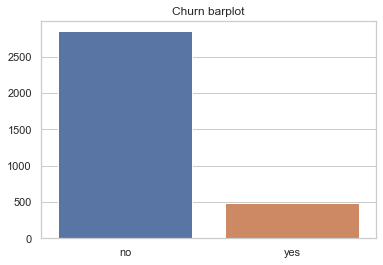

In [214]:
# churn values and proportion 
df = pd.DataFrame(pd.Categorical(df_train.churn).describe())
display(df)
 
# churn variable barplot
sns.set(style="whitegrid") 
sns.barplot(x=['no','yes'], y=df_train.churn.value_counts().values).set_title('Churn barplot')

As noticed on table and graph above, churn feature is unbalanced. About 14% of customers stopped using the telecom service and 85% still using it.

#### Categorical variables
##### State

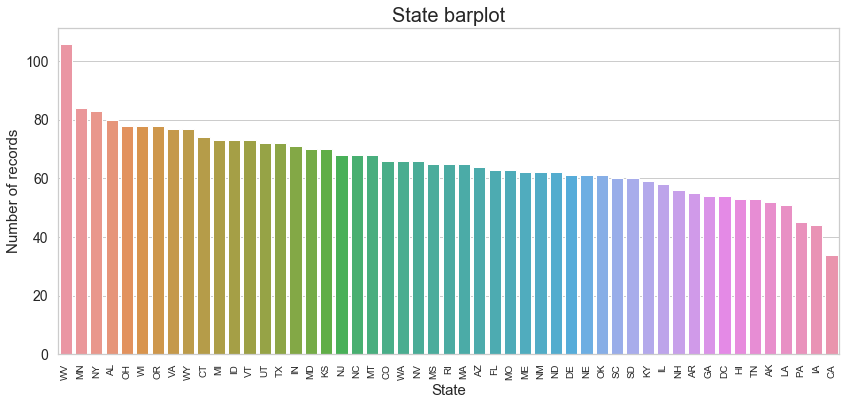

In [232]:
# State variable barplot
plt.figure(figsize=(14,6))

sns.barplot(x=df_train.state.value_counts().index,
            y=df_train.state.value_counts().values)

plt.title('State barplot', size=20)
plt.xlabel('State', size=15)
plt.ylabel('Number of records', size=15)
plt.yticks(fontsize=14)
plt.xticks(fontsize=10, rotation=90)
plt.show()

The state with the highest frequency is the West Virginia and the lowest frequency is the California.

In [28]:
# Import libraries
import folium
import os
 
# Load the shape of the zone (US states)
# Find the original file here: https://github.com/python-visualization/folium/tree/master/examples/data
# You have to download this file and set the directory where you saved it
state_geo = os.path.join('', 'us-states.json')
 
# Load the unemployment value of each state
# Find the original file here: https://github.com/python-visualization/folium/tree/master/examples/data
state_data = pd.DataFrame({'state': df_train.state.value_counts().index, 
                           'count': df_train.state.value_counts().values})
 
# Initialize the map:
m = folium.Map(location=[37, -102], zoom_start=5)
 
# Add the color for the chloropleth:
m.choropleth(
 geo_data=state_geo,
 name='Number of of records by state',
 data=state_data,
 columns=['state', 'count'],
 key_on='feature.id',
 fill_color='YlGn',
 fill_opacity=0.7,
 line_opacity=0.2,
 legend_name='Number of records'
)
folium.LayerControl().add_to(m)
 
# Save to html
m.save('#292_folium_chloropleth_USA1.html')